In [1]:
!pip install -U tensorflow


  Using cached tensorflow-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)
  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cach

In [1]:
import intake
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-08 16:40:15.272814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 16:40:15.423951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 16:40:15.423977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-08 16:40:15.459592: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 16:40:16.213998: W tensorflow/stream_executor/platform/de

In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

make_dir(train_path)
make_dir(test_path)

In [3]:
ds_forcing = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)

In [4]:
cat = intake.open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml')


In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33601")
client

<Client: 'tcp://127.0.0.1:33601' processes=4 threads=16, memory=58.88 GiB>

In [6]:
snapshots = cat["snapshots1ka"].to_dask()

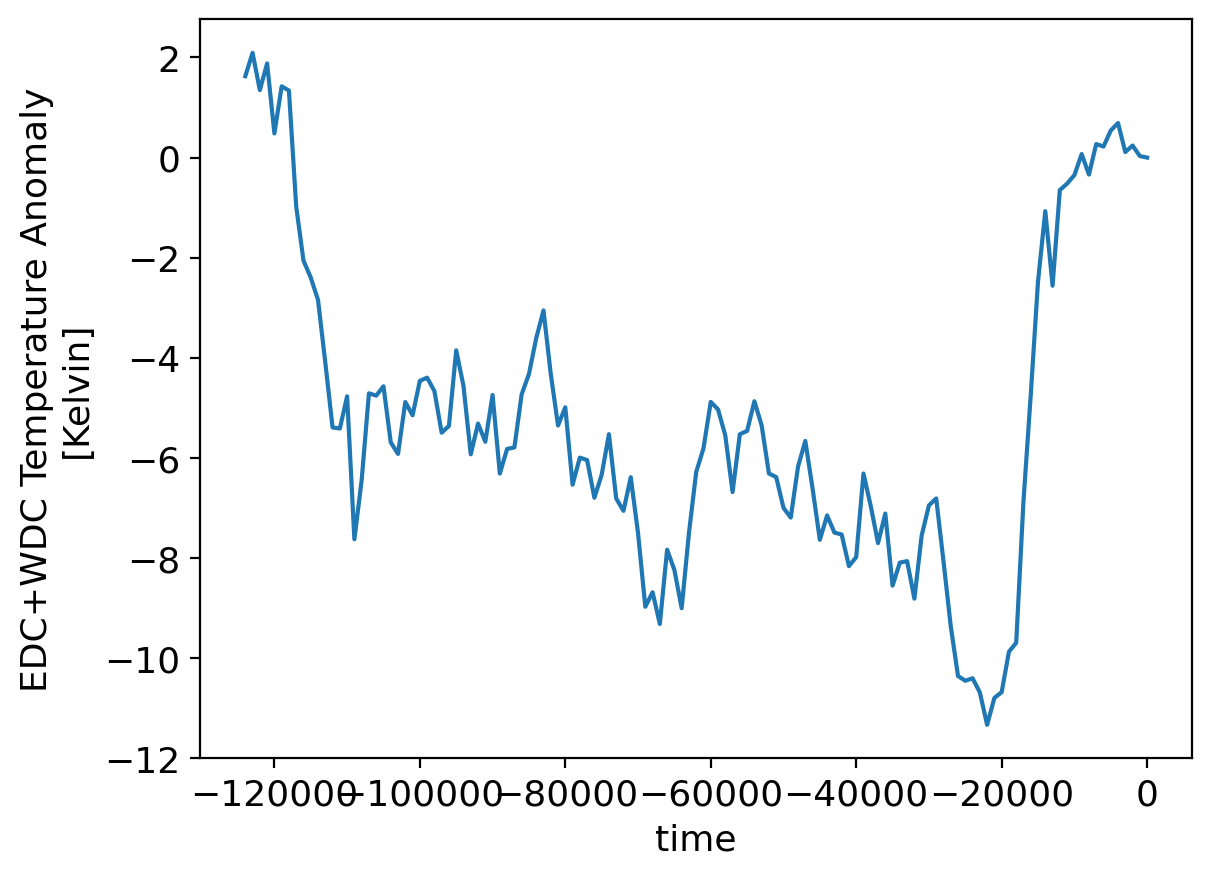

In [7]:
ds_forcing_interp = ds_forcing.interp(time=snapshots.time)
ds_forcing_interp.delta_T.plot()

In [8]:
ds_forcing_interp.delta_T.coords['time'].data

array([-124000., -123000., -122000., -121000., -120000., -119000.,
       -118000., -117000., -116000., -115000., -114000., -113000.,
       -112000., -111000., -110000., -109000., -108000., -107000.,
       -106000., -105000., -104000., -103000., -102000., -101000.,
       -100000.,  -99000.,  -98000.,  -97000.,  -96000.,  -95000.,
        -94000.,  -93000.,  -92000.,  -91000.,  -90000.,  -89000.,
        -88000.,  -87000.,  -86000.,  -85000.,  -84000.,  -83000.,
        -82000.,  -81000.,  -80000.,  -79000.,  -78000.,  -77000.,
        -76000.,  -75000.,  -74000.,  -73000.,  -72000.,  -71000.,
        -70000.,  -69000.,  -68000.,  -67000.,  -66000.,  -65000.,
        -64000.,  -63000.,  -62000.,  -61000.,  -60000.,  -59000.,
        -58000.,  -57000.,  -56000.,  -55000.,  -54000.,  -53000.,
        -52000.,  -51000.,  -50000.,  -49000.,  -48000.,  -47000.,
        -46000.,  -45000.,  -44000.,  -43000.,  -42000.,  -41000.,
        -40000.,  -39000.,  -38000.,  -37000.,  -36000.,  -350

In [9]:
X_df = pd.DataFrame({"delta_T": ds_forcing_interp.delta_T.data},index=ds_forcing_interp.delta_T.coords['time'].data)

First let's test by training on one ensemble member (will be overfit)

In [10]:
y_array = snapshots.velbar_mag.isel(par_esia=0,par_ppq=0,par_prec=0,par_visc=0).load()

In [11]:
y_array

<xarray.DataArray 'velbar_mag' (time: 125, y: 381, x: 381)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    par_esia  float64 1.0
    par_ppq   float64 0.25
    par_prec  float64 0.02
    par_visc  float64 1e+20
  * time      (time) float64 -1.24e+05 -1.23e+05 -1.22e+05 ... -2e+03 -1e+03 0.0
  * x         (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y         (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
Attributes:
    coordinates:  lat lon
    long_name:    magnitude of vertically-integrated horizontal velocity of ice
    pism_intent:  diagnostic
    units:        m year-1
    valid_min:    0.0

In [12]:
y_df_stack = y_array.stack(dim=["y", "x"])


In [13]:
y_df_stack

<xarray.DataArray 'velbar_mag' (time: 125, dim: 145161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    par_esia  float64 1.0
    par_ppq   float64 0.25
    par_prec  float64 0.02
    par_visc  float64 1e+20
  * time      (time) float64 -1.24e+05 -1.23e+05 -1.22e+05 ... -2e+03 -1e+03 0.0
  * dim       (dim) object MultiIndex
  * y         (dim) float64 -3.04e+06 -3.04e+06 -3.04e+06 ... 3.04e+06 3.04e+06
  * x         (dim) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Attributes:
    coordinates:  lat lon
    long_name:    magnitude of vertically-integrated horizontal velocity of ice
    pism_intent:  diagnostic
    units:        m year-1
    valid_min:    0.0

In [14]:
y_df = pd.DataFrame(y_df_stack.to_pandas())

In [15]:
y_df = y_df.fillna(0)

In [16]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2)

In [17]:
y_train_df.isnull().values.any()

False

In [18]:
print(X_train_df.shape,y_train_df.shape)

(100, 1) (100, 145161)


In [19]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(100, 1) (100, 145161)


In [23]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12,16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [24]:
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [25]:
reg0 = RandomForestRegressor(random_state=0)
# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_tas = rf_random0.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_tas.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the d

The best hyperparameters: 
 {'n_estimators': 300, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


In [ ]:
# If rerunning
n_estimators      = 300    # Number of trees in random forest
min_samples_split = 25     # Minimum number of samples required to split a node
min_samples_leaf  = 1      # Minimum number of samples required at each leaf node
max_features      = 'auto' # Number of features to consider at every split
max_depth         = None     # Maximum number of levels in tree
bootstrap         = False   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_tas = reg0.fit(X_train,y_train)

In [27]:
y_test_pre = rf_tas.predict(X_test)


In [28]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.index.values.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': y_test_df.index.values, 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velbar_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [29]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:     (time: 25, y: 381, x: 381)
Coordinates:
  * time        (time) float64 -1.17e+05 -8e+03 -2.7e+04 ... -3.9e+04 -1.07e+05
  * x           (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y           (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velbar_mag  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [30]:
y_true = y_test_df.unstack().to_xarray()

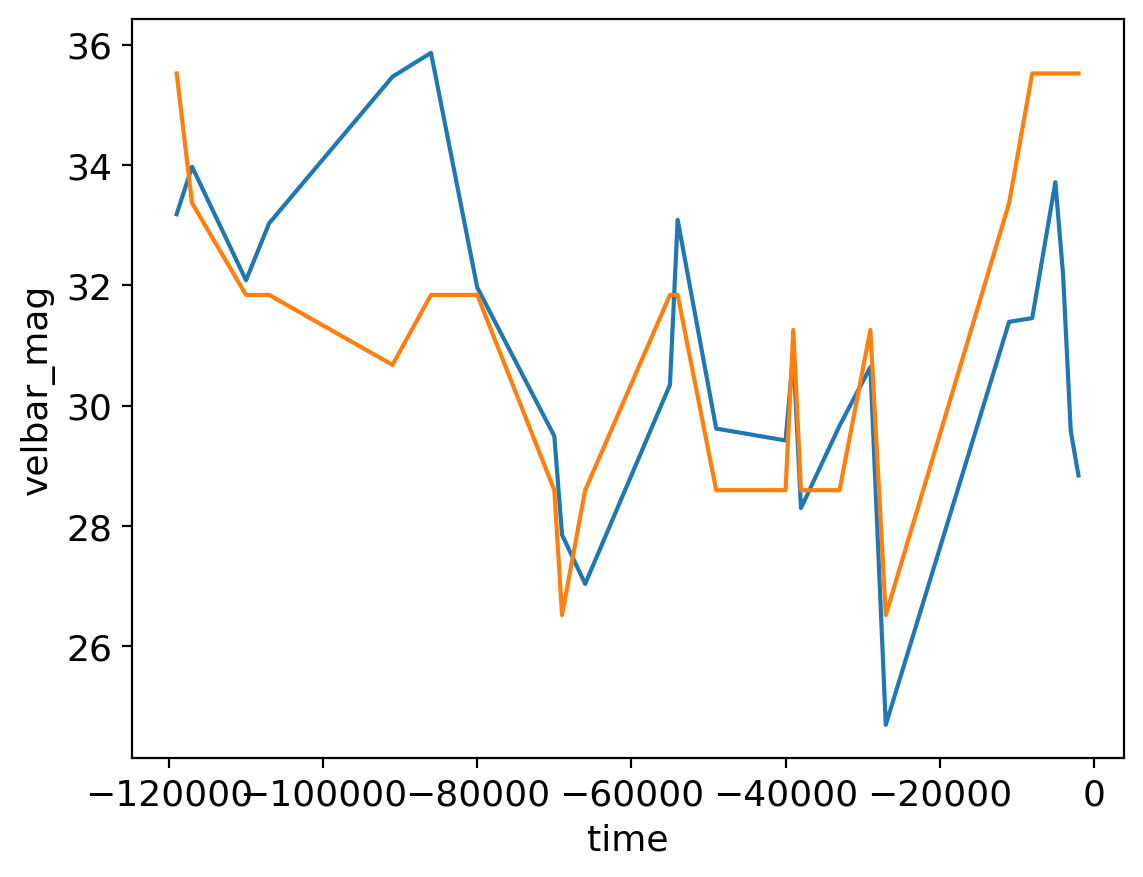

In [31]:
y_true.sortby(y_true.time).mean(dim=['x','y']).plot()
y_test_pre_xr.velbar_mag.sortby(y_test_pre_xr.time).mean(dim=['x','y']).plot()

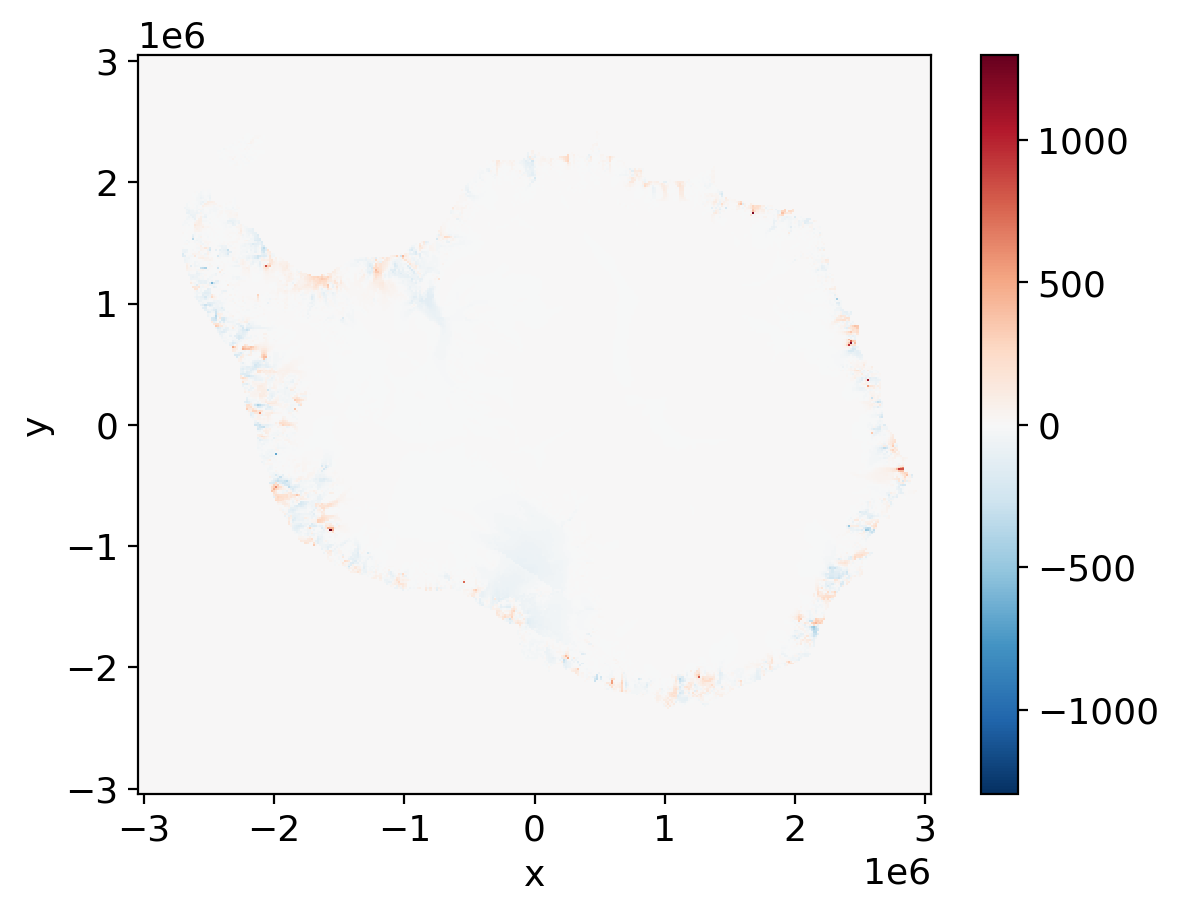

In [32]:
(y_true-y_test_pre_xr.velbar_mag).mean(dim='time').plot()

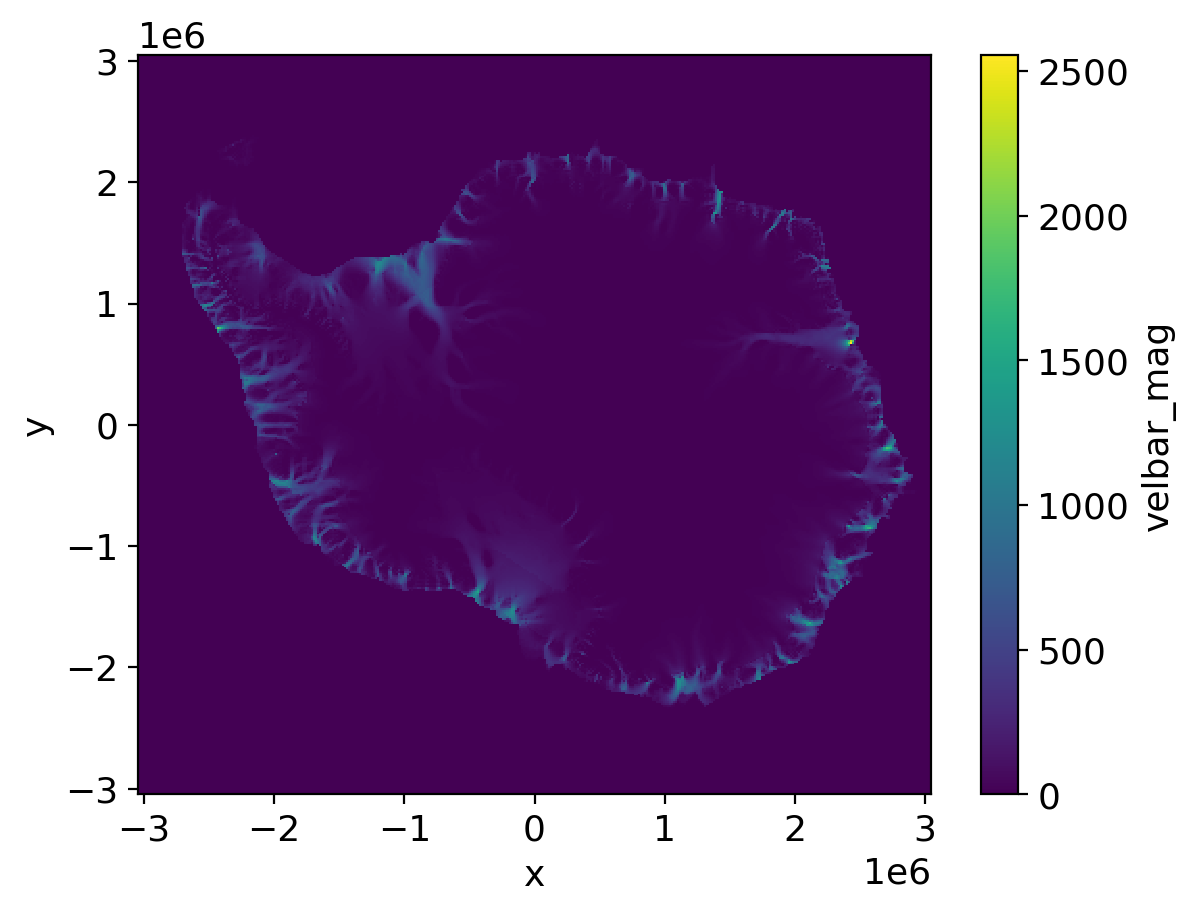

In [33]:
y_test_pre_xr.velbar_mag.mean(dim='time').plot()

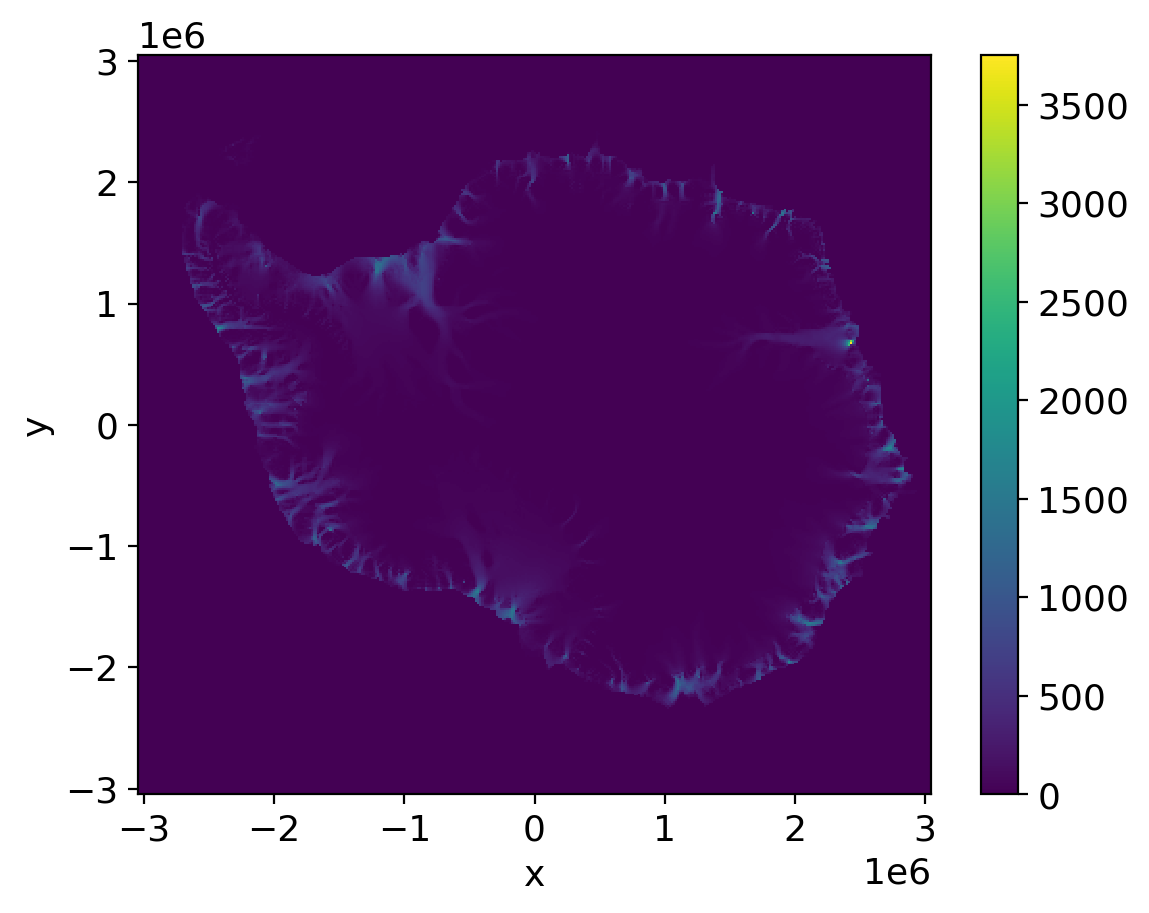

[CV] END bootstrap=False, max_depth=45, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  40.0s
[CV] END bootstrap=False, max_depth=45, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  40.0s
[CV] END bootstrap=False, max_depth=45, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  40.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time=  47.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time=  50.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time=  51.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=12, min_samples_split=25, n_estimators=200; total time=  56.5s
[CV] END bootstrap=False, max_depth=

In [34]:
y_true.mean(dim='time').plot()